In [1]:
import os
import json
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.appName('CreditCardFraudDetection').master("local[*]").config("spark.driver.memory", "4g").config("spark.sql.shuffle.partitions", "4").getOrCreate()

print(f"Spark Session Created with version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/20 01:10:17 WARN Utils: Your hostname, jiso-LOQ-15ARP9, resolves to a loopback address: 127.0.1.1; using 192.168.191.28 instead (on interface wlo1)
25/12/20 01:10:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/20 01:10:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session Created with version: 4.1.0


## Import Data

In [3]:
transactions_raw = spark.read.option("header", "true").option("inferSchema", "true").csv("../data/raw/transactions_data.csv")

cards_raw = spark.read.option("header", "true").option("inferSchema", "true").csv("../data/raw/cards_data.csv")

users_raw = spark.read.option("header", "true").option("inferSchema", "true").csv("../data/raw/users_data.csv")

### Transactions

In [4]:
transactions_raw.printSchema()
transactions_raw.show(5, vertical=True, truncate=False)
print(f"Row count: {transactions_raw.count()}")

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)

-RECORD 0-----------------------------
 id             | 7475327             
 date           | 2010-01-01 00:01:00 
 client_id      | 1556                
 card_id        | 2972                
 amount         | $-77.00             
 use_chip       | Swipe Transaction   
 merchant_id    | 59935               
 merchant_city  | Beulah              
 merchant_state | ND                  
 zip            | 58523.0             
 mcc            | 5499                
 errors         | NULL                
-RECORD 1

[Stage 7:==========>                                              (3 + 13) / 16]

Row count: 13305915


### Cards

In [5]:
cards_raw.printSchema()
cards_raw.show(5, vertical=True, truncate=False)
print(f"Row count: {cards_raw.count()}")

root
 |-- id: integer (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- expires: string (nullable = true)
 |-- cvv: integer (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: string (nullable = true)
 |-- acct_open_date: string (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- card_on_dark_web: string (nullable = true)

-RECORD 0---------------------------------
 id                    | 4524             
 client_id             | 825              
 card_brand            | NULL             
 card_type             | Debit            
 card_number           | 4344676511950444 
 expires               | 12/2022          
 cvv                   | 623              
 has_chip              | YES              
 num_cards_issued      | 2                
 credit

### Users

In [6]:
users_raw.printSchema()
users_raw.show(5, vertical=True, truncate=False)
print(f"Row count: {users_raw.count()}")

root
 |-- id: integer (nullable = true)
 |-- current_age: integer (nullable = true)
 |-- retirement_age: integer (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- birth_month: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- per_capita_income: string (nullable = true)
 |-- yearly_income: string (nullable = true)
 |-- total_debt: string (nullable = true)
 |-- credit_score: integer (nullable = true)
 |-- num_credit_cards: integer (nullable = true)

-RECORD 0-------------------------------------
 id                | 825                      
 current_age       | 53                       
 retirement_age    | 66                       
 birth_year        | 1966                     
 birth_month       | 11                       
 gender            | Female                   
 address           | 462 Rose Lane            
 latitude        

### Data Quality Check

In [ ]:
# Check for nulls and duplicates
def data_quality_check(df, name):
    print(f"\n=== {name} Quality Check ===")
    
    print("Null counts:")
    # df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

    null_counts_df = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    n_cols = len(df.columns)
    stack_string = f"stack({n_cols}, " + ", ".join([f"'{c}', `{c}`" for c in df.columns]) + ")"
    
    # 3. Select, filter, and show
    null_counts_df.select(expr(stack_string).alias("column_name", "null_count")) \
        .filter(col("null_count") > 0) \
        .show()
    
    # Total rows vs distinct rows
    total = null_counts_df.count()
    distinct = null_counts_df.distinct().count()
    print(f"Total rows: {total}")
    print(f"Distinct rows: {distinct}")
    print(f"Duplicates: {total - distinct}")

data_quality_check(transactions_raw, "TRANSACTIONS")
data_quality_check(cards_raw, "CARDS")
data_quality_check(users_raw, "USERS")

### Deeper transaction data analysis

In [7]:
transactions_raw.groupby("errors").count().orderBy(desc("count")).show(truncate=False)

[Stage 18:=================================================>      (14 + 2) / 16]

+-------------------------------------+--------+
|errors                               |count   |
+-------------------------------------+--------+
|NULL                                 |13094522|
|Insufficient Balance                 |130902  |
|Bad PIN                              |32119   |
|Technical Glitch                     |26271   |
|Bad Card Number                      |7767    |
|Bad Expiration                       |6161    |
|Bad CVV                              |6106    |
|Bad Zipcode                          |1126    |
|Bad PIN,Insufficient Balance         |293     |
|Insufficient Balance,Technical Glitch|243     |
|Bad Card Number,Insufficient Balance |71      |
|Bad PIN,Technical Glitch             |70      |
|Bad CVV,Insufficient Balance         |57      |
|Bad Expiration,Insufficient Balance  |47      |
|Bad Card Number,Bad CVV              |38      |
|Bad Card Number,Bad Expiration       |33      |
|Bad Expiration,Bad CVV               |32      |
|Bad Expiration,Tech

### Which merchant causing these errors?

In [8]:
transactions_raw.groupby("merchant_id", "errors").count().filter(col("errors").isNotNull()).orderBy(desc("count")).show()

[Stage 21:===================================>                    (10 + 6) / 16]

+-----------+--------------------+-----+
|merchant_id|              errors|count|
+-----------+--------------------+-----+
|      27092|Insufficient Balance|14662|
|      59935|Insufficient Balance| 8397|
|      61195|Insufficient Balance| 6110|
|      60569|Insufficient Balance| 4848|
|      22204|Insufficient Balance| 4383|
|      43293|Insufficient Balance| 4317|
|      26810|Insufficient Balance| 2732|
|      39021|Insufficient Balance| 2495|
|      20561|Insufficient Balance| 2423|
|      27092|             Bad PIN| 2310|
|      39021|     Bad Card Number| 2125|
|      50783|Insufficient Balance| 1874|
|      75781|Insufficient Balance| 1763|
|      39021|      Bad Expiration| 1746|
|      59935|             Bad PIN| 1726|
|      39021|             Bad CVV| 1666|
|      73186|Insufficient Balance| 1613|
|      48919|Insufficient Balance| 1322|
|      61195|             Bad PIN| 1241|
|      59935|    Technical Glitch| 1213|
+-----------+--------------------+-----+
only showing top

### Which users made most errors?

In [9]:
user_errors = transactions_raw.filter(col('errors').isNotNull()) \
    .join(users_raw, transactions_raw['client_id'] == users_raw['id'])

# 3. Use users_raw['id'] instead of just 'id' to avoid ambiguity errors
top_user_errors = user_errors.groupby(users_raw['id']).count().orderBy(desc('count'))

top_user_errors.show(truncate=False)

[Stage 25:================================>                        (9 + 7) / 16]

+----+-----+
|id  |count|
+----+-----+
|954 |2935 |
|1888|2109 |
|464 |1196 |
|1098|1125 |
|1696|953  |
|425 |847  |
|1424|822  |
|1382|821  |
|373 |816  |
|114 |796  |
|476 |741  |
|1885|713  |
|53  |675  |
|1963|654  |
|96  |617  |
|1340|611  |
|208 |601  |
|1797|599  |
|154 |593  |
|1241|552  |
+----+-----+
only showing top 20 rows


### Cleaned amount

In [10]:
transactions_raw = transactions_raw.withColumn(
    "amount_clean", 
    abs(regexp_replace(col("amount"), r'[$\,]', '').cast("double"))
)

### Extract Hour

In [ ]:
transactions_raw = transactions_raw.withColumn("hour", hour('date'))

### Impossible travel

It is impossible for a user to make a transaction from two different places within a short span of time.

In [11]:
windowSpec = Window.partitionBy("client_id", "card_id").orderBy("date")

travel_df = transactions_raw.withColumn("prev_zip", lag("zip").over(windowSpec)) \
                            .withColumn("prev_merchant_city", lag("merchant_city").over(windowSpec)) \
                            .withColumn("prev_merchant_state", lag("merchant_state").over(windowSpec)) \
                            .withColumn("prev_date", lag("date").over(windowSpec))

travel_df = travel_df.withColumn("diff_minutes", 
    (unix_timestamp("date") - unix_timestamp("prev_date")) / 60
)

travel_df = travel_df.withColumn("zip_changed",
    when((col("zip") != col("prev_zip")) & (col("prev_zip").isNotNull()), 1).otherwise(0)
)

travel_df = travel_df.withColumn("impossible_travel",
    when(
        (col("zip_changed") == 1) & 
        (col("diff_minutes") < 60) &
        (col("diff_minutes") > 0),  
        1
    ).otherwise(0)
)

print("=== IMPOSSIBLE TRAVEL STATISTICS ===")
travel_df.groupBy("impossible_travel").count().show()

print("\n=== IMPOSSIBLE TRAVEL EXAMPLES ===")
impossible_cases = travel_df.filter(col("impossible_travel") == 1) \
                            .select(
                                "client_id", "card_id",
                                "prev_zip", "zip",
                                "prev_merchant_city", "merchant_city",
                                "prev_merchant_state", "merchant_state", 
                                "prev_date", "date",
                                "diff_minutes",
                                "amount"
                            )

impossible_cases.show(20, truncate=False)
print(f"\nTotal impossible travel cases: {impossible_cases.count():,}")

=== IMPOSSIBLE TRAVEL STATISTICS ===


+-----------------+--------+
|impossible_travel|   count|
+-----------------+--------+
|                0|12841694|
|                1|  464221|
+-----------------+--------+


=== IMPOSSIBLE TRAVEL EXAMPLES ===


+---------+-------+--------+-------+------------------+-------------+-------------------+--------------+-------------------+-------------------+------------+------+
|client_id|card_id|prev_zip|zip    |prev_merchant_city|merchant_city|prev_merchant_state|merchant_state|prev_date          |date               |diff_minutes|amount|
+---------+-------+--------+-------+------------------+-------------+-------------------+--------------+-------------------+-------------------+------------+------+
|2        |3593   |10460.0 |10469.0|Bronx             |Bronx        |NY                 |NY            |2015-12-19 21:55:00|2015-12-19 22:04:00|9.0         |$32.45|
|2        |3593   |10462.0 |10460.0|Bronx             |Bronx        |NY                 |NY            |2016-02-09 21:35:00|2016-02-09 22:19:00|44.0        |$13.50|
|2        |3593   |10466.0 |10460.0|Bronx             |Bronx        |NY                 |NY            |2017-08-05 14:52:00|2017-08-05 14:55:00|3.0         |$11.18|
|2        

[Stage 39:===========================================>              (3 + 1) / 4]


Total impossible travel cases: 464,221


### Add impossible travel col to the dataset

In [12]:
transactions_raw = travel_df.withColumn("travel_risk_level",
    when(
        (col("zip_changed") == 1) & 
        (col("prev_merchant_state") != col("merchant_state")) &
        (col("diff_minutes") < 30),
        "critical"
    )
    .when(
        (col("zip_changed") == 1) & 
        (col("diff_minutes") < 60),
        "high"
    )
    .when(
        (col("zip_changed") == 1) & 
        (col("diff_minutes") < 180),
        "medium"
    )
    .otherwise("low")
)

print("=== TRAVEL RISK DISTRIBUTION ===")
transactions_raw.groupBy("travel_risk_level").count().orderBy(desc("count")).show()

=== TRAVEL RISK DISTRIBUTION ===


[Stage 45:===========================================>              (3 + 1) / 4]

+-----------------+--------+
|travel_risk_level|   count|
+-----------------+--------+
|              low|12295530|
|           medium|  542123|
|             high|  448057|
|         critical|   20205|
+-----------------+--------+



### Card testing

If the card has been used to withdraw money frequently in a short span of time, it is a clear indication that it is a fraudulant transaction.

In [13]:
window_10min = Window.partitionBy("card_id") \
                     .orderBy(unix_timestamp(col("date"))) \
                     .rangeBetween(-600, 0)

transactions_raw = transactions_raw.withColumn(
    "total_txn_count_10min",
    count("*").over(window_10min)
)

# Flag cards with >5 transactions in 10 minutes
transactions_raw = transactions_raw.withColumn(
    "is_high_velocity",
    when(col("total_txn_count_10min") >= 5, 1).otherwise(0)
)

print("\n=== HIGH VELOCITY DETECTION ===")
transactions_raw.groupBy("is_high_velocity").count().show()

high_velocity = transactions_raw.filter(col("is_high_velocity") == 1) \
                           .select(
                               "client_id", "card_id", "date", 
                               "amount_clean", "total_txn_count_10min",
                               "merchant_city", "errors"
                           ) \
                           .orderBy(desc("total_txn_count_10min"), "card_id", "date")

high_velocity.show(30, truncate=False)
print(f"High velocity transactions: {high_velocity.count():,}")


=== HIGH VELOCITY DETECTION ===


+----------------+--------+
|is_high_velocity|   count|
+----------------+--------+
|               0|13301943|
|               1|    3972|
+----------------+--------+



+---------+-------+-------------------+------------+---------------------+-------------------------+--------------------+
|client_id|card_id|date               |amount_clean|total_txn_count_10min|merchant_city            |errors              |
+---------+-------+-------------------+------------+---------------------+-------------------------+--------------------+
|144      |5247   |2014-10-31 10:19:00|79.0        |8                    |Hot Springs National Park|NULL                |
|1362     |0      |2015-08-17 07:17:00|21.51       |7                    |Burke                    |NULL                |
|171      |1239   |2015-11-12 17:32:00|77.56       |7                    |Greenville               |NULL                |
|171      |1239   |2015-11-12 17:35:00|69.0        |7                    |Greenville               |NULL                |
|1424     |4876   |2018-05-10 07:26:00|77.0        |7                    |Kingman                  |NULL                |
|144      |5247   |2014-

[Stage 60:>                                                         (0 + 4) / 4]

High velocity transactions: 3,972


In [14]:
transactions_raw = transactions_raw.withColumn(
    "error_type",
    when(col("errors").contains("Bad PIN"), "card_testing")
    .when(col("errors").contains("Bad Card Number"), "card_testing")
    .when(col("errors").contains("Bad CVV"), "card_testing")
    .when(col("errors").contains("Bad Expiration"), "card_testing")
    .when(col("errors").contains("Bad Zipcode"), "card_testing")
    .when(col("errors").contains("Insufficient Balance"), "legitimate")
    .when(col("errors").contains("Technical Glitch"), "legitimate")
    .otherwise("no_error")
)

In [15]:
transactions_raw.groupBy("error_type").count().show()

[Stage 64:===================================>                    (10 + 6) / 16]

+------------+--------+
|  error_type|   count|
+------------+--------+
|card_testing|   53977|
|    no_error|13094522|
|  legitimate|  157416|
+------------+--------+



In [20]:
with open('../data/raw/train_fraud_labels.json', 'r') as f:
    json_data = json.load(f)

target_dict = json_data.get('target', json_data)

# Write to CSV
with open('../data/processed/fraud_labels.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'is_fraud_label'])
    
    for id_str, label_str in target_dict.items():
        try:
            transaction_id = int(id_str)
            is_fraud = 1 if label_str.lower() == "yes" else 0
            writer.writerow([transaction_id, is_fraud])
        except:
            continue

print("✅ Saved as CSV!")

# Read with Spark
fraud_labels = spark.read.csv(
    '../data/processed/fraud_labels.csv',
    header=True,
    inferSchema=True
)

print(f"Total labels: {fraud_labels.count():,}")
fraud_labels.groupBy("is_fraud_label").count().show()

✅ Saved as CSV!


ConnectionRefusedError: [Errno 111] Connection refused

In [53]:
transactions_raw = transactions_raw.withColumn("year", year("date")) \
                                   .withColumn("month", month("date"))

In [18]:
transactions_raw.groupBy("year", "month").count().orderBy("year", "month").show()

[Stage 63:=================================================>      (14 + 2) / 16]

+----+-----+------+
|year|month| count|
+----+-----+------+
|2010|    1|101209|
|2010|    2| 93470|
|2010|    3|103345|
|2010|    4|100169|
|2010|    5|104773|
|2010|    6|102677|
|2010|    7|106034|
|2010|    8|107547|
|2010|    9|103902|
|2010|   10|106150|
|2010|   11|103721|
|2010|   12|107883|
|2011|    1|107821|
|2011|    2| 97395|
|2011|    3|108235|
|2011|    4|105662|
|2011|    5|108946|
|2011|    6|106239|
|2011|    7|110196|
|2011|    8|111001|
+----+-----+------+
only showing top 20 rows


In [19]:
partitions = transactions_raw.select("year", "month").distinct().collect()

print(f"\nTotal partitions: {len(partitions)}")

[Stage 66:====================================================>   (15 + 1) / 16]


Total partitions: 118


In [20]:
indexer = StringIndexer(inputCol="use_chip", outputCol="chip_indexed")
transactions_raw = indexer.fit(transactions_raw).transform(transactions_raw)

In [21]:
transactions_raw.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- amount_clean: double (nullable = true)
 |-- prev_zip: double (nullable = true)
 |-- prev_merchant_city: string (nullable = true)
 |-- prev_merchant_state: string (nullable = true)
 |-- prev_date: timestamp (nullable = true)
 |-- diff_minutes: double (nullable = true)
 |-- zip_changed: integer (nullable = false)
 |-- impossible_travel: integer (nullable = false)
 |-- travel_risk_level: string (nullable = false)
 |-- total_txn_count_10min: long (nullable = false)
 |-- is_high_velocity: integer (nullable = fal

In [22]:
feature_cols = ["amount_clean", "hour", "chip_indexed", "is_high_velocity", "impossible_travel"]

In [23]:
essential_cols = [
    "id", "date", "amount_clean", "hour", "chip_indexed",
    "is_high_velocity", "impossible_travel", "is_suspected_fraud"
]

# Filter to only needed columns
df_minimal = transactions_raw.select(essential_cols)

print(f"Original columns: {len(transactions_raw.columns)}")
print(f"Minimal columns: {len(df_minimal.columns)}")

# 2. Stratified sampling - balance classes
fraud_data = df_minimal.filter(col("is_suspected_fraud") == 1)
fraud_count = fraud_data.count()

print(f"\n=== DATA DISTRIBUTION ===")
print(f"Total fraud cases: {fraud_count:,}")

# Sample: ALL fraud + equal non-fraud
non_fraud_sample = df_minimal.filter(col("is_suspected_fraud") == 0) \
                             .sample(False, fraud_count / df_minimal.count(), seed=42)

# Combine
balanced_data = fraud_data.union(non_fraud_sample)
balanced_data = balanced_data.cache()  # Cache AFTER union

print(f"Balanced dataset: {balanced_data.count():,} rows")
balanced_data.groupBy("is_suspected_fraud").count().show()

# 3. Prepare features
feature_cols = ["amount_clean", "hour", "chip_indexed", "is_high_velocity", "impossible_travel"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

feature_data = assembler.transform(balanced_data)
feature_data = feature_data.withColumn("label", col("is_suspected_fraud"))

# 4. Train/test split
train, test = feature_data.randomSplit([0.8, 0.2], seed=42)

# CRITICAL: Cache splits
train = train.cache()
test = test.cache()

# Force materialization
train_count = train.count()
test_count = test.count()

print(f"\n=== SPLIT COMPLETE ===")
print(f"Training: {train_count:,} rows")
print(f"Test: {test_count:,} rows")

# 5. Train model (simplified)
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=20,
    maxDepth=6,
    maxBins=24,
    seed=42
)

print("\n Training model...") 
model = rf.fit(train)
print("Training complete!")

# 6. Evaluate
predictions = model.transform(test)

evaluator = BinaryClassificationEvaluator(labelCol="label")
auc = evaluator.evaluate(predictions)

print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion matrix
print("\n=== CONFUSION MATRIX ===")
predictions.groupBy("label", "prediction").count().show()

# Additional metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

precision = MulticlassClassificationEvaluator(
    labelCol="label", metricName="weightedPrecision"
).evaluate(predictions)

recall = MulticlassClassificationEvaluator(
    labelCol="label", metricName="weightedRecall"
).evaluate(predictions)

f1 = MulticlassClassificationEvaluator(
    labelCol="label", metricName="f1"
).evaluate(predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 7. Feature importance
print("\n=== FEATURE IMPORTANCE ===")
importances = model.featureImportances.toArray()
for feat, imp in sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# 8. Save model
os.makedirs("../models", exist_ok=True)
model_path = "../models/fraud_detection_rf_final"
model.write().overwrite().save(model_path)
print(f"\n✅ Model saved: {model_path}")

# 9. Cleanup
train.unpersist()
test.unpersist()
balanced_data.unpersist()

Original columns: 29
Minimal columns: 8



=== DATA DISTRIBUTION ===
Total fraud cases: 520,829


Balanced dataset: 1,020,988 rows
+------------------+------+
|is_suspected_fraud| count|
+------------------+------+
|                 1|520829|
|                 0|500159|
+------------------+------+




=== SPLIT COMPLETE ===
Training: 817,062 rows
Test: 203,926 rows

🔄 Training model...
✅ Training complete!

MODEL PERFORMANCE
AUC-ROC: 0.9632

=== CONFUSION MATRIX ===
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|93619|
|    1|       0.0|10476|
|    0|       0.0|99831|
+-----+----------+-----+

Precision: 0.9535
Recall: 0.9486
F1-Score: 0.9485

=== FEATURE IMPORTANCE ===
impossible_travel: 0.9773
is_high_velocity: 0.0153
chip_indexed: 0.0069
hour: 0.0004
amount_clean: 0.0001


25/12/19 22:07:58 ERROR Utils: Aborting task
org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/home/jiso/Documents/EPITA/Spark/Final_Project/Scalable-Credit-Card-Fraud-Detection-Behavior-Analysis/models/fraud_detection_rf_final/treesMetadata. SQLSTATE: 58030
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:814)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.enrichWriteError(FileFormatDataWriter.scala:92)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.commit(FileFormatDataWriter.scala:123)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1337)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:418)
	at org.apache.spark.sql.execution.datasources.

Py4JJavaError: An error occurred while calling o1221.save.
: org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/home/jiso/Documents/EPITA/Spark/Final_Project/Scalable-Credit-Card-Fraud-Detection-Behavior-Analysis/models/fraud_detection_rf_final/treesMetadata. SQLSTATE: 58030
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:814)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.enrichWriteError(FileFormatDataWriter.scala:92)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.commit(FileFormatDataWriter.scala:123)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1337)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:418)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:107)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:180)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:679)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:86)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:83)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:97)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:682)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1017)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2496)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:309)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:270)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:396)
	at org.apache.spark.sql.execution.adaptive.ResultQueryStageExec.$anonfun$doMaterialize$1(QueryStageExec.scala:328)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:334)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:284)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:332)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:328)
	at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1768)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1453)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:160)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:239)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:592)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:115)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:369)
	at org.apache.spark.ml.util.ReadWriteUtils$.saveArray(ReadWrite.scala:1126)
	at org.apache.spark.ml.tree.EnsembleModelReadWrite$.saveImpl(treeModels.scala:542)
	at org.apache.spark.ml.classification.RandomForestClassificationModel$RandomForestClassificationModelWriter.saveImpl(RandomForestClassifier.scala:429)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:176)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:814)
		at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.enrichWriteError(FileFormatDataWriter.scala:92)
		at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.commit(FileFormatDataWriter.scala:123)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:407)
		at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1337)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:418)
		at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:107)
		at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
		at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
		at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
		at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
		at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
		at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
		at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:180)
		at org.apache.spark.scheduler.Task.run(Task.scala:147)
		at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:679)
		at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:86)
		at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:83)
		at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:97)
		at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:682)
		at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
		at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
		at java.base/java.lang.Thread.run(Thread.java:1583)
		at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1017)
		at org.apache.spark.SparkContext.runJob(SparkContext.scala:2496)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:309)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:270)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
		at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
		at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:396)
		at org.apache.spark.sql.execution.adaptive.ResultQueryStageExec.$anonfun$doMaterialize$1(QueryStageExec.scala:328)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$4(SQLExecution.scala:334)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:284)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$3(SQLExecution.scala:332)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withThreadLocalCaptured$2(SQLExecution.scala:328)
		at java.base/java.util.concurrent.CompletableFuture$AsyncSupply.run(CompletableFuture.java:1768)
		at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
		at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
		... 1 more
Caused by: java.lang.UnsatisfiedLinkError: /tmp/snappy-1.1.10-f600c1a0-b312-4de5-a880-e4612d49f7b4-libsnappyjava.so: libc.musl-x86_64.so.1: cannot open shared object file: No such file or directory
	at java.base/jdk.internal.loader.NativeLibraries.load(Native Method)
	at java.base/jdk.internal.loader.NativeLibraries$NativeLibraryImpl.open(NativeLibraries.java:331)
	at java.base/jdk.internal.loader.NativeLibraries.loadLibrary(NativeLibraries.java:197)
	at java.base/jdk.internal.loader.NativeLibraries.loadLibrary(NativeLibraries.java:139)
	at java.base/java.lang.ClassLoader.loadLibrary(ClassLoader.java:2418)
	at java.base/java.lang.Runtime.load0(Runtime.java:852)
	at java.base/java.lang.System.load(System.java:2025)
	at org.xerial.snappy.SnappyLoader.loadNativeLibrary(SnappyLoader.java:182)
	at org.xerial.snappy.SnappyLoader.loadSnappyApi(SnappyLoader.java:157)
	at org.xerial.snappy.Snappy.init(Snappy.java:70)
	at org.xerial.snappy.Snappy.<clinit>(Snappy.java:47)
	at org.apache.parquet.hadoop.codec.SnappyCompressor.maxCompressedLength(SnappyCompressor.java:29)
	at org.apache.parquet.hadoop.codec.NonBlockedCompressor.compress(NonBlockedCompressor.java:77)
	at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
	at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
	at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:234)
	at org.apache.parquet.hadoop.ColumnChunkPageWriteStore$ColumnChunkPageWriter.writePage(ColumnChunkPageWriteStore.java:203)
	at org.apache.parquet.column.impl.ColumnWriterV1.writePage(ColumnWriterV1.java:71)
	at org.apache.parquet.column.impl.ColumnWriterBase.writePage(ColumnWriterBase.java:379)
	at org.apache.parquet.column.impl.ColumnWriteStoreBase.flush(ColumnWriteStoreBase.java:191)
	at org.apache.parquet.column.impl.ColumnWriteStoreV1.flush(ColumnWriteStoreV1.java:29)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.flushRowGroupToStore(InternalParquetRecordWriter.java:216)
	at org.apache.parquet.hadoop.InternalParquetRecordWriter.close(InternalParquetRecordWriter.java:134)
	at org.apache.parquet.hadoop.ParquetRecordWriter.close(ParquetRecordWriter.java:223)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.close(ParquetOutputWriter.scala:41)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.releaseCurrentWriter(FileFormatDataWriter.scala:69)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.releaseResources(FileFormatDataWriter.scala:80)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.$anonfun$commit$2(FileFormatDataWriter.scala:124)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.enrichWriteError(FileFormatDataWriter.scala:84)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.commit(FileFormatDataWriter.scala:123)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1337)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:418)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:107)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:901)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:901)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:180)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:679)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:86)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:83)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:97)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:682)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
	Suppressed: java.lang.NoClassDefFoundError: Could not initialize class org.xerial.snappy.Snappy
		at org.apache.parquet.hadoop.codec.SnappyCompressor.maxCompressedLength(SnappyCompressor.java:29)
		at org.apache.parquet.hadoop.codec.NonBlockedCompressor.compress(NonBlockedCompressor.java:77)
		at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
		at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
		at org.apache.hadoop.io.compress.CompressionOutputStream.close(CompressionOutputStream.java:64)
		at org.apache.hadoop.io.compress.CompressorStream.close(CompressorStream.java:106)
		at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:235)
		... 34 more
	Caused by: java.lang.ExceptionInInitializerError: Exception java.lang.UnsatisfiedLinkError: /tmp/snappy-1.1.10-f600c1a0-b312-4de5-a880-e4612d49f7b4-libsnappyjava.so: libc.musl-x86_64.so.1: cannot open shared object file: No such file or directory [in thread "Executor task launch worker for task 0.0 in stage 210.0 (TID 675)"]
		at java.base/jdk.internal.loader.NativeLibraries.load(Native Method)
		at java.base/jdk.internal.loader.NativeLibraries$NativeLibraryImpl.open(NativeLibraries.java:331)
		at java.base/jdk.internal.loader.NativeLibraries.loadLibrary(NativeLibraries.java:197)
		at java.base/jdk.internal.loader.NativeLibraries.loadLibrary(NativeLibraries.java:139)
		at java.base/java.lang.ClassLoader.loadLibrary(ClassLoader.java:2418)
		at java.base/java.lang.Runtime.load0(Runtime.java:852)
		at java.base/java.lang.System.load(System.java:2025)
		at org.xerial.snappy.SnappyLoader.loadNativeLibrary(SnappyLoader.java:182)
		at org.xerial.snappy.SnappyLoader.loadSnappyApi(SnappyLoader.java:157)
		at org.xerial.snappy.Snappy.init(Snappy.java:70)
		at org.xerial.snappy.Snappy.<clinit>(Snappy.java:47)
		at org.apache.parquet.hadoop.codec.SnappyCompressor.maxCompressedLength(SnappyCompressor.java:29)
		at org.apache.parquet.hadoop.codec.NonBlockedCompressor.compress(NonBlockedCompressor.java:77)
		at org.apache.hadoop.io.compress.CompressorStream.compress(CompressorStream.java:81)
		at org.apache.hadoop.io.compress.CompressorStream.finish(CompressorStream.java:92)
		at org.apache.parquet.hadoop.CodecFactory$HeapBytesCompressor.compress(CodecFactory.java:234)
		... 34 more


### Error Distribution

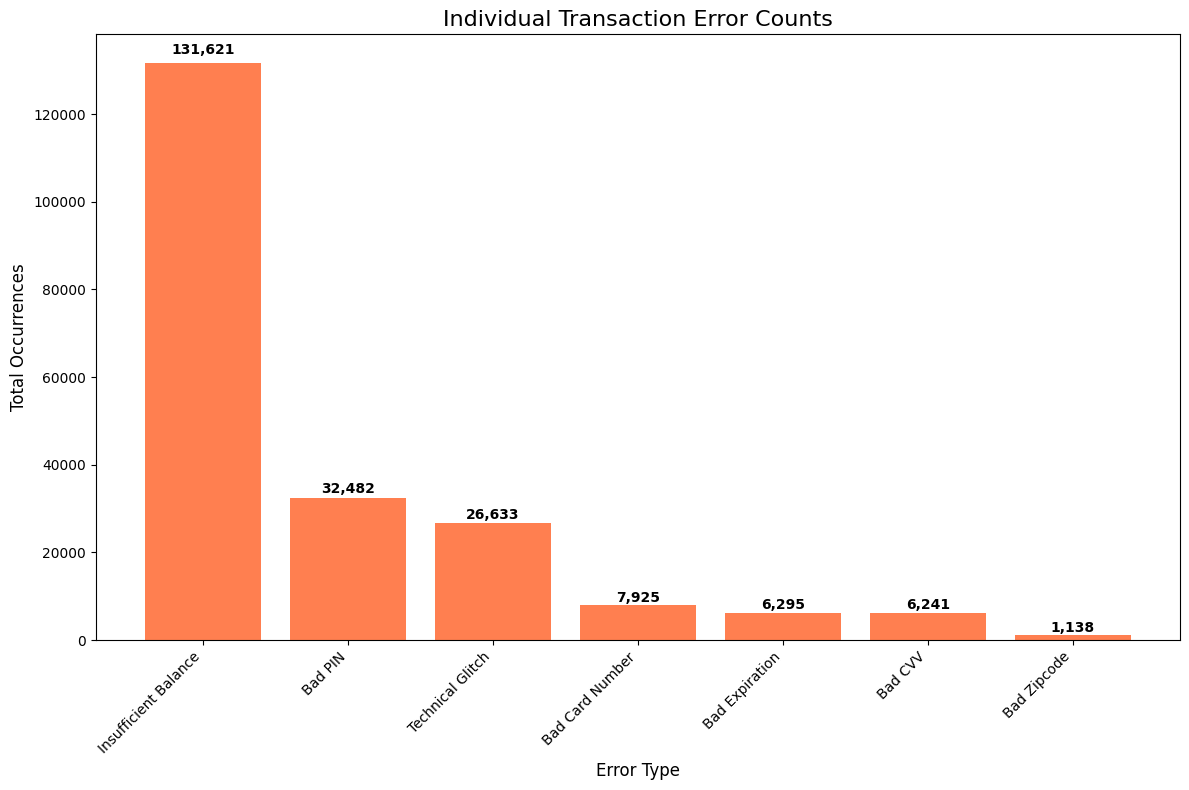

In [34]:
flattened_errors = transactions_raw.filter(col("errors").isNotNull()) \
    .withColumn("single_error", explode(split(col("errors"), ",\s*"))) \
    .withColumn("single_error", trim(col("single_error"))) \
    .groupBy("single_error") \
    .count() \
    .orderBy(desc("count")) \
    .toPandas()

plt.figure(figsize=(12, 8))

bars = plt.bar(flattened_errors['single_error'], flattened_errors['count'], color='#ff7f50')

plt.title('Individual Transaction Error Counts', fontsize=16)
plt.xlabel('Error Type', fontsize=12)
plt.ylabel('Total Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
             f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('flattened_errors_chart.png') # Saving for the environment
plt.show()

## Which age group made the most errors?

In [38]:
user_errors_with_bins = user_errors.withColumn(
    "age_group",
    when(col("current_age") <= 25, "18-25")
     .when(col("current_age") <= 40, "26-40")
     .when(col("current_age") <= 60, "41-60")
     .otherwise("60+")
)

# 2. Now aggregate
age_group_counts = user_errors_with_bins.groupBy("age_group").count().orderBy("age_group")

age_group_counts.show()

[Stage 293:===============================>                        (9 + 7) / 16]

+---------+-----+
|age_group|count|
+---------+-----+
|    18-25|  669|
|    26-40|42183|
|    41-60|97653|
|      60+|70888|
+---------+-----+



/tmp/ipykernel_608868/2329069051.py:16: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='count', data=age_group_counts_pd, palette='viridis')


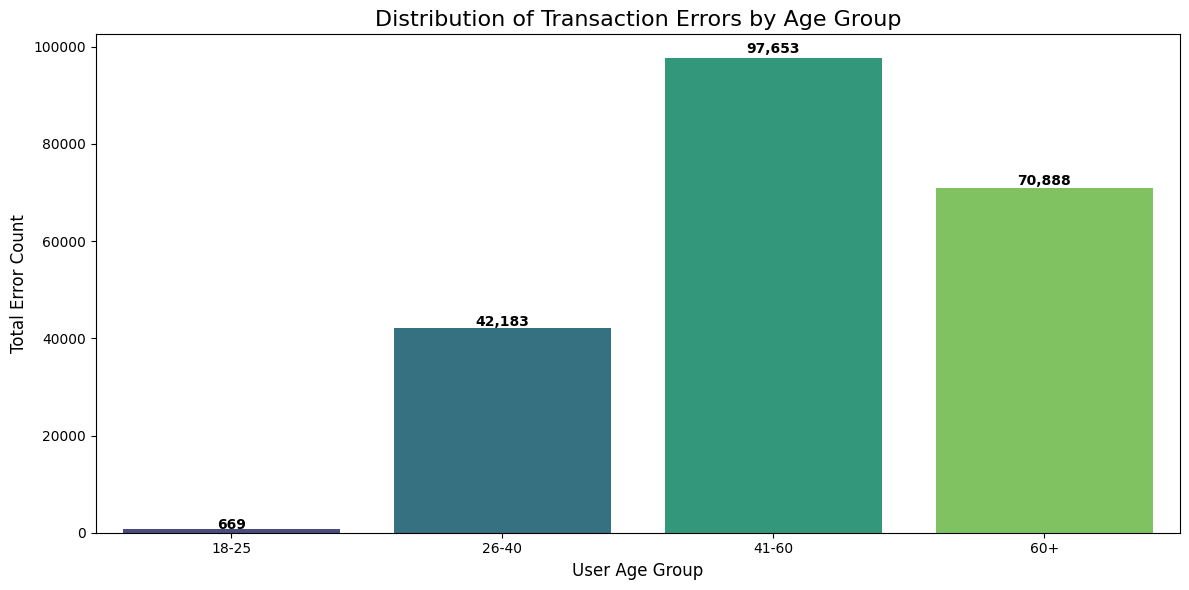

In [43]:
# 1. Create age groups and aggregate in Spark
age_group_counts_spark = user_errors.withColumn(
    "age_group",
    when(col("current_age") <= 25, "18-25")
     .when(col("current_age") <= 40, "26-40")
     .when(col("current_age") <= 60, "41-60")
     .otherwise("60+")
).groupBy("age_group").count().orderBy("age_group")

# 2. CONVERT TO PANDAS HERE (The "Fix")
# We do this now because the data is only 4 rows - very safe for memory.
age_group_counts_pd = age_group_counts_spark.toPandas()

# 3. Use the Pandas DataFrame for Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='count', data=age_group_counts_pd, palette='viridis')

plt.title('Distribution of Transaction Errors by Age Group', fontsize=16)
plt.xlabel('User Age Group', fontsize=12)
plt.ylabel('Total Error Count', fontsize=12)

# 4. Use the Pandas column for the labels
for i, v in enumerate(age_group_counts_pd['count']):
    plt.text(i, v + (v * 0.01), f'{int(v):,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [48]:
user_spending_tiers = user_spending.join(users_raw, user_spending.client_id == users_raw.id) \
    .withColumn("Credit_Tier", 
        when(col("credit_score") >= 800, "7. Exceptional (800+)")
         .when(col("credit_score") >= 740, "6. Very Good (740-799)")
         .when(col("credit_score") >= 670, "5. Good (670-739)")
         .when(col("credit_score") >= 580, "4. Fair (580-669)")
         .otherwise("3. Poor (<580)")) \
    .select("Credit_Tier", "total_spent")

# 2. Sample and convert to Pandas
# Use a sample so the Violin plot doesn't take forever to calculate
plot_df = user_spending_tiers.sample(False, 0.1, seed=42).toPandas()

/tmp/ipykernel_608868/715171762.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Credit_Tier', y='total_spent', data=plot_df,


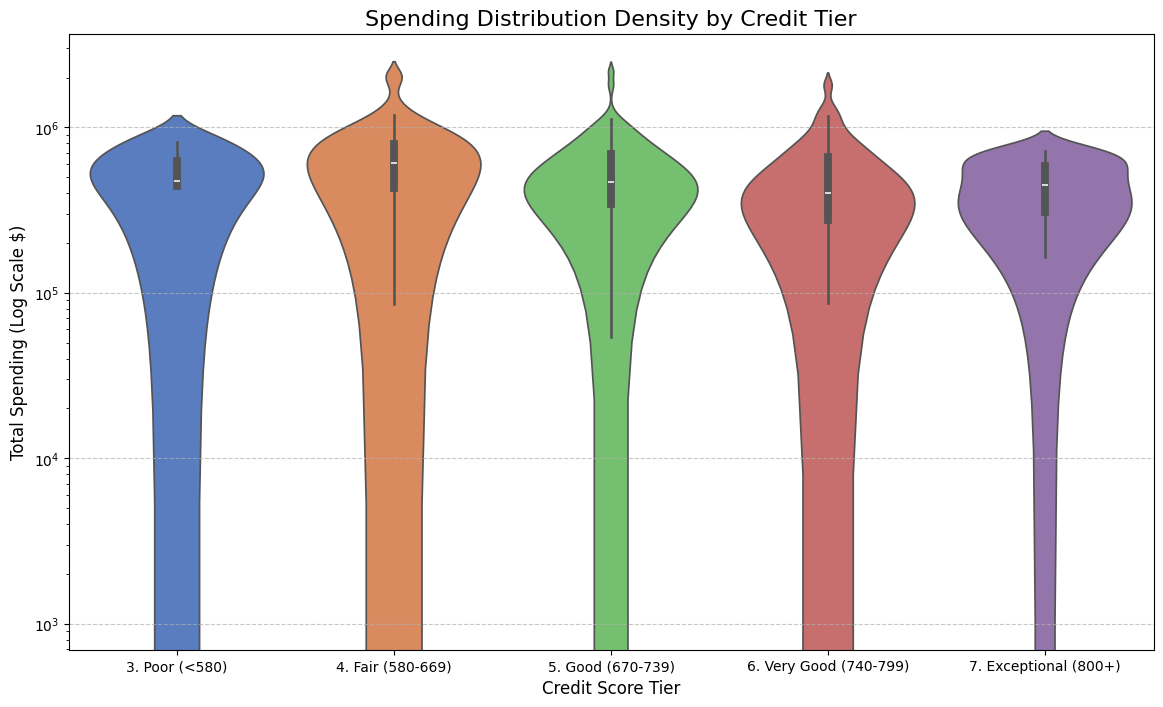

In [49]:
plt.figure(figsize=(14, 8))

# We use a log scale for the Y-axis because spending ranges from $1 to $100,000+
sns.violinplot(x='Credit_Tier', y='total_spent', data=plot_df, 
               palette="muted", order=sorted(plot_df['Credit_Tier'].unique()))

plt.yscale('log') # CRITICAL: This allows us to see the $100 and $10,000 users on the same map
plt.title('Spending Distribution Density by Credit Tier', fontsize=16)
plt.xlabel('Credit Score Tier', fontsize=12)
plt.ylabel('Total Spending (Log Scale $)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()